In [2]:
import random
import numpy as np 
from PIL import Image
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Normalize
from data_generation.image_classification import generate_dataset 
from helpers import index_splitter, make_balanced_sampler
from stepbystep.v1 import StepByStep

### Convolution

In [3]:
single = np.array(
    [[[[5, 0, 8, 7, 8, 1],
       [1, 9, 5, 0, 7, 7],
       [6, 0, 2, 4, 6, 6],
       [9, 7, 6, 6, 8, 4],
       [8, 3, 8, 5, 1, 3],
       [7, 2, 7, 0, 1, 0]]]]
)

In [5]:
identity = np.array(
    [[[[0, 0, 0],
       [0, 1, 0],
[0, 0, 0]]]] )

In [6]:
single.shape,identity.shape

((1, 1, 6, 6), (1, 1, 3, 3))

In [7]:
region = single[:,:,0:3,0:3]
filtered_region = region * identity
# total = filtered_region.sum()
filtered_region


array([[[[0, 0, 0],
         [0, 9, 0],
         [0, 0, 0]]]])

In [9]:
filtered_region.sum()

9

In [10]:
image = torch.as_tensor(single).float()
kernel_identity = torch.as_tensor(identity).float()

In [11]:
convolved = F.conv2d(image,kernel_identity,stride=1)
convolved

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]])

In [12]:
conv = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=3,stride=1)

In [13]:
conv(image)

tensor([[[[-1.2006,  0.7110, -2.2756, -2.0855],
          [-1.7658, -3.3200, -3.8066, -0.7085],
          [-5.2944, -2.1759, -1.4969, -0.7776],
          [-3.9149,  0.4376, -0.3669,  0.5336]]]],
       grad_fn=<ConvolutionBackward0>)

In [14]:
conv_multiple = nn.Conv2d(
    in_channels=1, out_channels=2, kernel_size=3, stride=1
)
conv_multiple.weight

Parameter containing:
tensor([[[[-0.1082,  0.1204,  0.0951],
          [-0.0598, -0.2422,  0.1361],
          [ 0.0646, -0.2401, -0.1386]]],


        [[[ 0.1076, -0.1885,  0.0439],
          [-0.1912,  0.3027,  0.0755],
          [-0.0358, -0.0004,  0.2823]]]], requires_grad=True)

In [15]:
with torch.no_grad():
    conv.weight[0] = kernel_identity 
    conv.bias[0] = 0

In [16]:
conv(image)

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]], grad_fn=<ConvolutionBackward0>)

In [17]:
convolved_stride2 = F.conv2d(image, kernel_identity, stride=2)
convolved_stride2

tensor([[[[9., 0.],
          [7., 6.]]]])

In [19]:
constant_padder = nn.ConstantPad2d(padding=1, value=0)
constant_padder(image)

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

In [21]:
padded = F.pad(image,pad = (1,1,1,1),mode = 'constant',value=0)
padded

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

In [22]:
# edge detection

edge = np.array(
    [[[[0,  1, 0],
       [1, -4, 1],
[0, 1, 0]]]] )

kernel_edge = torch.as_tensor(edge).float()
kernel_edge

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])

In [24]:
padded = F.pad(image, (1, 1, 1, 1), mode='constant', value=0)
conv_padded = F.conv2d(padded,kernel_edge,stride = 1)

### Pooling

In [27]:
#by default stride is assumed the size of the kernel
pooled = F.max_pool2d(conv_padded, kernel_size=2)
pooled

tensor([[[[22., 23., 11.],
          [24.,  7.,  1.],
          [13., 13., 13.]]]])

In [28]:
maxpool4 = nn.MaxPool2d(kernel_size=4)
pooled4 = maxpool4(conv_padded)
pooled4

tensor([[[[24.]]]])

In [29]:
#stride value
F.avg_pool2d(conv_padded,kernel_size = 3,stride = 1)

tensor([[[[-1.6667,  1.2222, -3.1111, -2.6667],
          [-2.6667,  1.0000,  0.4444, -2.3333],
          [-2.2222,  1.5556, -1.5556, -2.4444],
          [-7.1111, -1.2222, -3.1111,  0.0000]]]])

### Flatten

In [30]:
flattened = nn.Flatten()(pooled)
flattened

tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]])

In [37]:
pooled.view(1,-1),pooled.view(1,-1).shape

(tensor([[22., 23., 11., 24.,  7.,  1., 13., 13., 13.]]), torch.Size([1, 9]))

In [35]:
pooled.squeeze(),pooled.squeeze().shape

(tensor([[22., 23., 11.],
         [24.,  7.,  1.],
         [13., 13., 13.]]),
 torch.Size([3, 3]))

In [34]:
pooled,pooled.shape

(tensor([[[[22., 23., 11.],
           [24.,  7.,  1.],
           [13., 13., 13.]]]]),
 torch.Size([1, 1, 3, 3]))

### Multi class classification

In [38]:
images, labels = generate_dataset(
  img_size=10, n_images=1000, binary=False, seed=17
)

In [39]:
class TransformedTensorDataset(Dataset):

    def __init__(self,x,y,transform = None):

        self.x = x
        self.y = y
        self.transform = transform
    
    def __getitem__(self, index):
        x = self.x[index]

        if self.transform:
            x = self.transform(x)
        
        return x,self.y[index]
    
    def __len__(self):
        return len(self.x)

In [40]:
#data prep

x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels).long()

train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor,
            transform=train_composer)

val_dataset = TransformedTensorDataset(x_val_tensor,y_val_tensor,
                                    transform=val_composer)

sampler = make_balanced_sampler(y_train_tensor)

train_loader = DataLoader(train_dataset,batch_size=16,sampler=sampler)

val_loader = DataLoader(val_dataset,batch_size = 16)

#### loss

In [43]:
logits = torch.tensor([ 1.3863,  0.0000, -0.6931])

In [44]:
nn.Softmax(dim = -1)(logits), F.softmax(logits,dim=-1)

(tensor([0.7273, 0.1818, 0.0909]), tensor([0.7273, 0.1818, 0.0909]))

In [45]:
log_probs = F.log_softmax(logits, dim=-1)
log_probs

tensor([-0.3185, -1.7048, -2.3979])

In [46]:
# last layer is log_softmax -> loss is nn.NLLLoss
# last layer is softmax (produces logits as o/p)--> loss is nn.CrossEntropyLoss

In [47]:
torch.manual_seed(11)
dummy_logits = torch.randn((5, 3))
dummy_labels = torch.tensor([0, 0, 1, 2, 1])

In [49]:
loss_fn = nn.CrossEntropyLoss()
loss_fn(dummy_logits,dummy_labels)

tensor(1.6553)

### Model configuration

Featurizer

In [53]:
torch.manual_seed(13)
model_cnn1 = nn.Sequential()

n_channels = 1

model_cnn1.add_module('conv1',nn.Conv2d(in_channels=1,out_channels=n_channels,kernel_size=3))
model_cnn1.add_module('relu1',nn.ReLU())
model_cnn1.add_module('maxp1',nn.MaxPool2d(kernel_size=2))

#flatten
model_cnn1.add_module('flatten',nn.Flatten())

Classifier

In [54]:
model_cnn1.add_module('fc1',nn.Linear(n_channels*4*4,10))
model_cnn1.add_module('relu2',nn.ReLU())
#output layer
model_cnn1.add_module('fc2',nn.Linear(10,3)) #3 because no of labels is 3

In [55]:
model_cnn1

Sequential(
  (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16, out_features=10, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=10, out_features=3, bias=True)
)

Loss and optimizer

In [56]:
lr = 0.1

multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.SGD(model_cnn1.parameters(),lr = lr)

#### Training

In [57]:
sbs_cnn1 = StepByStep(model_cnn1, multi_loss_fn, optimizer,mps=True)
sbs_cnn1.set_loaders(train_loader, val_loader)

In [58]:
sbs_cnn1.train(20)

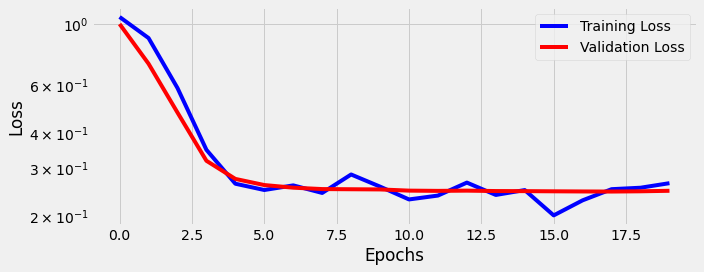

In [59]:
fig = sbs_cnn1.plot_losses()